# Model Benchmark Example

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import logging
logging.basicConfig(level=logging.INFO)
from time import time

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import chainer
from chainercv.links import ResNet50, SEResNet50, SEResNeXt50, VGG16, SSD300

from chainerpruner import Pruner, Graph
from chainerpruner.masks import NormMask
from chainerpruner.utils import calc_computational_cost

## Model definitions

In [2]:
models = {
    'VGG16': {
        'input_shape': (1, 3, 224, 224),
        'model': lambda: VGG16(n_class=1000),
        'target_layers': [
            '/conv1_1/conv',
            '/conv1_2/conv',
            '/conv2_1/conv',
            '/conv2_2/conv',
            '/conv3_2/conv',
            '/conv3_3/conv',
            '/conv4_1/conv',
            '/conv4_2/conv',
            '/conv4_3/conv',
            '/conv5_1/conv',
            '/conv5_2/conv',
            '/conv5_3/conv',
        ],
        'color': 'r',
    },
    'ResNet50': {
        'input_shape': (1, 3, 224, 224),
        'model': lambda: ResNet50(n_class=1000),
        'target_layers': [
            "/res2/a/conv1/conv",
            "/res2/a/conv2/conv",
            "/res2/a/conv3/conv",
            "/res2/a/residual_conv/conv",
            "/res2/b1/conv2/conv",
            "/res2/b1/conv3/conv",
            "/res2/b2/conv2/conv",
            "/res2/b2/conv3/conv",
            "/res3/a/conv2/conv",
            "/res3/a/conv3/conv",
            "/res3/a/residual_conv/conv",
            "/res3/b1/conv2/conv",
            "/res3/b2/conv2/conv",
            "/res3/b3/conv2/conv",
            "/res3/b1/conv3/conv",
            "/res3/b2/conv3/conv",
            "/res3/b3/conv3/conv",
            "/res4/a/conv2/conv",
            "/res4/a/conv3/conv",
            "/res4/a/residual_conv/conv",
            "/res4/b1/conv2/conv",
            "/res4/b2/conv2/conv",
            "/res4/b3/conv2/conv",
            "/res4/b4/conv2/conv",
            "/res4/b5/conv2/conv",
            "/res4/b1/conv3/conv",
            "/res4/b2/conv3/conv",
            "/res4/b3/conv3/conv",
            "/res4/b4/conv3/conv",
            "/res4/b5/conv3/conv",
            "/res5/a/conv2/conv",
            "/res5/a/conv3/conv",
            "/res5/a/residual_conv/conv",
            "/res5/b1/conv2/conv",
            "/res5/b2/conv2/conv",
            "/res5/b1/conv3/conv",
            "/res5/b2/conv3/conv",
        ],
        'color': 'b',
    },
    'SEResNet50': {
        'input_shape': (1, 3, 224, 224),
        'model': lambda: SEResNet50(n_class=1000),
        'target_layers': [
            "/res2/a/conv2/conv",
            "/res2/a/conv3/conv",
            "/res2/a/residual_conv/conv",
            "/res2/b1/conv2/conv",
            "/res2/b1/conv3/conv",
            "/res2/b2/conv2/conv",
            "/res2/b2/conv3/conv",
            "/res3/a/conv2/conv",
            "/res3/a/conv3/conv",
            "/res3/a/residual_conv/conv",
            "/res3/b1/conv2/conv",
            "/res3/b2/conv2/conv",
            "/res3/b3/conv2/conv",
            "/res3/b1/conv3/conv",
            "/res3/b2/conv3/conv",
            "/res3/b3/conv3/conv",
            "/res4/a/conv2/conv",
            "/res4/a/conv3/conv",
            "/res4/a/residual_conv/conv",
            "/res4/b1/conv2/conv",
            "/res4/b2/conv2/conv",
            "/res4/b3/conv2/conv",
            "/res4/b4/conv2/conv",
            "/res4/b5/conv2/conv",
            "/res4/b1/conv3/conv",
            "/res4/b2/conv3/conv",
            "/res4/b3/conv3/conv",
            "/res4/b4/conv3/conv",
            "/res4/b5/conv3/conv",
            "/res5/a/conv2/conv",
            "/res5/a/conv3/conv",
            "/res5/a/residual_conv/conv",
            "/res5/b1/conv2/conv",
            "/res5/b2/conv2/conv",
            "/res5/b1/conv3/conv",
            "/res5/b2/conv3/conv",
        ],
        'color': 'g',
    },
    'SEResNeXt50': {
        'input_shape': (1, 3, 224, 224),
        'model': lambda: SEResNeXt50(n_class=1000),
        'target_layers': [
            "/res2/a/conv3/conv",
            "/res2/a/residual_conv/conv",
            "/res2/b1/conv3/conv",
            "/res2/b2/conv3/conv",
            "/res3/a/conv3/conv",
            "/res3/a/residual_conv/conv",
            "/res3/b1/conv3/conv",
            "/res3/b2/conv3/conv",
            "/res3/b3/conv3/conv",
            "/res4/a/conv3/conv",
            "/res4/a/residual_conv/conv",
            "/res4/b1/conv3/conv",
            "/res4/b2/conv3/conv",
            "/res4/b3/conv3/conv",
            "/res4/b4/conv3/conv",
            "/res4/b5/conv3/conv",
            "/res5/a/conv3/conv",
            "/res5/a/residual_conv/conv",
            "/res5/b1/conv3/conv",
            "/res5/b2/conv3/conv",
        ],
        'color': 'c',
    },
    'SSD300': {
        'input_shape': (1, 3, 300, 300),
        'model': lambda: SSD300(n_fg_class=20),
        'target_layers': [
            "/extractor/conv1_1",
            "/extractor/conv1_2",
            "/extractor/conv2_1",
            "/extractor/conv2_2",
            "/extractor/conv3_1",
            "/extractor/conv3_2",
            "/extractor/conv3_3",
            "/extractor/conv4_1",
            "/extractor/conv4_2",
#             "/extractor/conv4_3",
            "/extractor/conv5_1",
            "/extractor/conv5_2",
            "/extractor/conv5_3",
            "/extractor/conv6",
            "/extractor/conv7",
            "/extractor/conv8_1",
            "/extractor/conv8_2",
            "/extractor/conv9_1",
            "/extractor/conv9_2",
            "/extractor/conv10_1",
            "/extractor/conv10_2",
            "/extractor/conv11_1",
            "/extractor/conv11_2",
        ],
        'color': 'm',
    },
}

## Benchmark

In [3]:
n_loops = 10
percent = [0.25, 0.5, 0.75]
task_list = [] # all
# task_list = ['SSD300']

In [4]:
def benchmark(model, n_loops):
    times = np.zeros((n_loops), dtype=np.float32)
    for i in range(n_loops):
        start = time()
        model(x)
        elapsed = time() - start
        times[i] = elapsed
    return times

In [5]:
results = []
for name, target in models.items():
    x = np.zeros(target['input_shape'], dtype=np.float32)
    model = target['model']()
    
    if task_list and name not in task_list:
        continue

    cch = calc_computational_cost(model, x)
    gflops = cch.summary_report["total"]["flops"] / 1e+9
    print(f'{name} {gflops:.2f} [GFLOPs]')

    times = benchmark(model, n_loops)
    
    results.append({
        'name': name,
        'time-mean-sec': times.mean(),
        'time-std-sec': times.std(),
        'gflops': gflops,
        'params': model.count_params(),
        'pruning-rate': 0.,
    })

    target_layers = target['target_layers']
    
    for p in percent:
        model = target['model']()
            
        graph = Graph(model, x)
        mask = NormMask(model, graph, target_layers, percent=p)
        pruner = Pruner(model, x, target_layers, mask)
        pruner.apply_mask()
        info = pruner.apply_rebuild()

        cch = calc_computational_cost(model, x)
        gflops = cch.summary_report["total"]["flops"] / 1e+9
        print(f'{name} {gflops:.2f} [GFLOPs] {p:.0%} pruning')

        times = benchmark(model, n_loops)
        
        results.append({
            'name': name,
            'time-mean-sec': times.mean(),
            'time-std-sec': times.std(),
            'gflops': gflops,
            'params': model.count_params(),
            'pruning-rate': p,
        })

VGG16 15.49 [GFLOPs]
VGG16 9.28 [GFLOPs] 25% pruning
VGG16 4.63 [GFLOPs] 50% pruning
VGG16 1.55 [GFLOPs] 75% pruning
ResNet50 4.12 [GFLOPs]
ResNet50 2.89 [GFLOPs] 25% pruning
ResNet50 1.81 [GFLOPs] 50% pruning
ResNet50 0.89 [GFLOPs] 75% pruning
SEResNet50 3.90 [GFLOPs]
SEResNet50 2.75 [GFLOPs] 25% pruning
SEResNet50 1.74 [GFLOPs] 50% pruning
SEResNet50 0.87 [GFLOPs] 75% pruning
SEResNeXt50 4.28 [GFLOPs]
SEResNeXt50 3.25 [GFLOPs] 25% pruning
SEResNeXt50 2.26 [GFLOPs] 50% pruning
SEResNeXt50 1.31 [GFLOPs] 75% pruning
SSD300 31.41 [GFLOPs]
SSD300 18.90 [GFLOPs] 25% pruning
SSD300 9.61 [GFLOPs] 50% pruning
SSD300 3.53 [GFLOPs] 75% pruning


In [6]:
df = pd.DataFrame(results)

In [7]:
cols = ['name', 'pruning-rate', 'gflops', 'params', 'time-mean-sec', 'time-std-sec']
df[cols]

,name,pruning-rate,gflops,params,time-mean-sec,time-std-sec
0,VGG16,0.00,15.488423,138357544,0.598160,0.029863
1,VGG16,0.25,9.280730,106396824,0.364254,0.022930
2,VGG16,0.50,4.633711,76164104,0.242314,0.019328
3,VGG16,0.75,1.547367,47659384,0.109590,0.005331
4,ResNet50,0.00,4.117136,25557032,0.283600,0.014854
5,ResNet50,0.25,2.885393,17706152,0.229223,0.012967
6,ResNet50,0.50,1.809396,10832680,0.205960,0.030918
7,ResNet50,0.75,0.889146,4936616,0.151841,0.011635
8,SEResNet50,0.00,3.898457,28088024,0.297543,0.026534
9,SEResNet50,0.25,2.746109,19612600,0.266881,0.020759


Text(0.5, 0, 'operations [GFLOPs]')

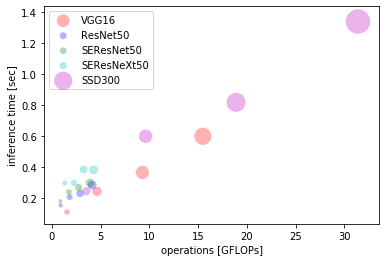

In [8]:
ax = plt.subplot()
names = df['name'].unique()
for name, model in models.items():
    c = model['color']
    
    df_ = df.query('name == @name')
    if len(df_) == 0:
        continue
        
    s = df_['gflops'] / df['gflops'].max() * 600

    df_.plot.scatter(
        x='gflops', y='time-mean-sec',
                     s=s, c=c, alpha=0.3, edgecolors='none',
                     label=name, ax=ax
                    )
ax.set_ylabel('inference time [sec]')
ax.set_xlabel('operations [GFLOPs]')

In [9]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 158
model name	: Intel(R) Core(TM) i9-8950HK CPU @ 2.90GHz
stepping	: 10
cpu MHz		: 2900.000
cache size	: 12288 KB
physical id	: 0
siblings	: 1
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 22
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht pbe syscall nx pdpe1gb lm constant_tsc rep_good nopl xtopology nonstop_tsc pni pclmulqdq dtes64 ds_cpl ssse3 sdbg fma cx16 xtpr pcid sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch kaiser fsgsbase bmi1 hle avx2 bmi2 erms rtm xsaveopt arat
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf
bogomips	: 5808.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 39 bits physical, 48 bits virtual
power management:

processor	: 1
vendor_id	: GenuineIntel
cpu family	: 6
model		: 158
model name	: Intel(R) C